# Phase Field Method
Author: Xuan Hu

Date: 2025-02-09

This section shows how to solve the phase field PDE together with linear problem with staggered scheme.

Xuan's phase field framework is adopted here.

$$\delta\Pi_u=\int_\Omega\left[H(\phi-\phi_{cr})+k\right]\sigma_{ij}\delta\epsilon_{ij}\,\mathrm{d}\Omega$$

$$\delta\Pi_\phi=\int_\Omega \frac{2\pi \langle\sigma_{\theta\theta}\rangle_+^2}{E'}(\phi-2)\delta\phi +  
G_c\left[l_0\frac{\partial\phi}{\partial x_i} \frac{\partial\phi}{\partial x_i}+\frac{1}{l_0}\phi\delta\phi\right]\,\mathrm{d}\Omega$$

We start by importing DOLFINx and some additional dependencies.

In [1]:
from mpi4py import MPI
from dolfinx import mesh, fem, io, plot, nls, log, geometry, la
from dolfinx import cpp as _cpp
from dolfinx import default_real_type
import basix
import dolfinx.fem.petsc
import ufl
import numpy as np
import matplotlib.pyplot as plt
from petsc4py.PETSc import ScalarType
from petsc4py import PETSc
import time
import os
import meshio

### Specify controlling parameters

In [2]:
# Elasticity parameters
E = ScalarType(210.0e3)
nu = ScalarType(0.3)
plane_type = 'e'
if plane_type == 's':
    mu, lmbda, kappa = E/(2.0*(1.0+nu)), E*nu/((1.0+nu)*(1.0-nu)), E/(2.0*(1.0-nu))
    E_frac = E
    kappa = (3.0-nu) / (1.0+nu)
elif plane_type == 'e':
    mu, lmbda, kappa = E/(2.0*(1.0+nu)), E*nu/((1.0+nu)*(1.0-2.0*nu)), E/(3.0*(1.0-2.0*nu))
    E_frac = E / (1.0-nu**2)
    kappa = 3.0-4.0*nu

meshsz = ScalarType(0.0025)
# Phase field parameters
Gc = ScalarType(2.7)
l0 = 2.0 * meshsz
constk = ScalarType(1.0e-5)
phicr = ScalarType(0.95)
alpha = ScalarType(1.0)

# Geometric parameters
W_geom = 1.0
L_geom = 1.0

Lnotch = 0.5

# Loading condition
uD_1_step = 2.5e-5
uD_1_step_extra = 5.0e-7
n_step = 400
iprint = 20
critical_step = 181

### Create geometry model and function spaces

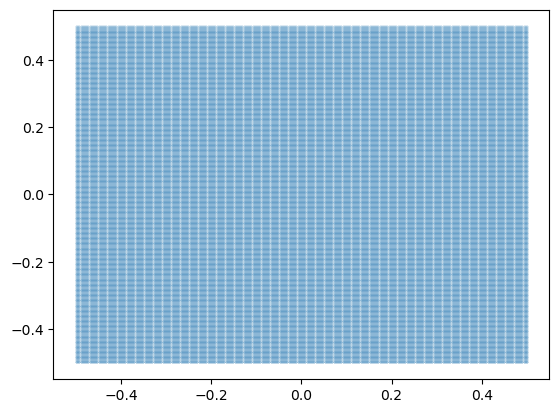

In [3]:
comm = MPI.COMM_WORLD
comm_rank = MPI.COMM_WORLD.rank
log.set_log_level(log.LogLevel.ERROR)

n0_mesh = int(W_geom/meshsz)
if np.mod(n0_mesh, 2) == 0:
    n0_mesh += 1
n1_mesh = int(W_geom/meshsz)
if np.mod(n1_mesh, 2) == 0:
    n1_mesh += 1

domain = mesh.create_rectangle(comm = comm,
                               points=[np.array([-0.5*W_geom,-0.5*L_geom]), np.array([0.5*W_geom,0.5*L_geom])],
                               n=[n0_mesh, n1_mesh],
                               cell_type=mesh.CellType.quadrilateral,
                               diagonal=mesh.DiagonalType.left_right)
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim - 1)
domain.topology.create_connectivity(domain.topology.dim-1, 0)
f2v = domain.topology.connectivity(domain.topology.dim-1, 0)

order_in = domain.geometry.input_global_indices
ndim = domain.topology.dim
topo, cells, geom = plot.vtk_mesh(domain, ndim)

plt.scatter(geom[:,0], geom[:, 1], s=0.01, marker='o')

V = fem.functionspace(domain, ("CG", 1, (ndim,)))
Y = fem.functionspace(domain, ("CG", 1))
YH = fem.functionspace(domain, ("DG", 0))

### Define boundary conditions

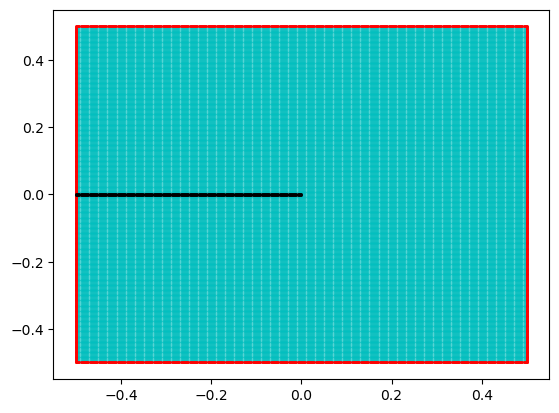

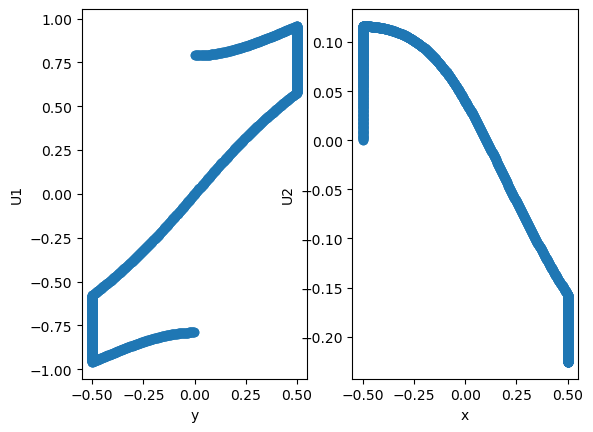

In [4]:
def down(x):
    return (np.abs(x[1]+0.5*L_geom) <= 0.1*meshsz)

def up(x):
    return (np.abs(x[1]-0.5*L_geom) <= 0.1*meshsz)

def notch(x):
    return (x[1] < 0.7*meshsz) & (x[1] >= -0.7*meshsz) & (x[0] <= -0.5*W_geom + Lnotch)

fdim = domain.topology.dim - 1
facets_u = mesh.locate_entities_boundary(domain, fdim, up)
facets_d = mesh.locate_entities_boundary(domain, fdim, down)
entity_notch = mesh.locate_entities(domain, fdim, notch)
facets_all = mesh.exterior_facet_indices(domain.topology)

# identify the dofs located on the boundaries and notch
dofs_ub = fem.locate_dofs_topological(V, fdim, facets_all)
dofs_notch = fem.locate_dofs_topological(Y, fdim, entity_notch)

# visualize the boundary conditions
dofs_ub0 = fem.locate_dofs_topological(V.sub(0), fdim, facets_all)
dofs_ub1 = fem.locate_dofs_topological(V.sub(1), fdim, facets_all)
nodes_ub = dofs_ub0 // 2 # this is an ad-hoc method
nodes_phib = dofs_notch
plt.scatter(geom[:, 0], geom[:, 1], s=0.1, marker='o', color='c')
plt.scatter(geom[nodes_ub, 0], geom[nodes_ub, 1], s=1, marker='o', color='r')
plt.scatter(geom[nodes_phib, 0], geom[nodes_phib, 1], s=1, marker='o', color='k')
plt.show()

# define displacement boundary conditions 
class DefineDisp:
    def __init__(self):
        self.t = 0.0

    def eval_u(self, x):
        r_val = np.sqrt(x[0, :]**2 + x[1, :]**2)
        t_val = np.arccos(x[0, :]/r_val)
        tmp_idx = np.where(x[1, :] < 0.0)
        t_val[tmp_idx] *= -1.0
        u_vals = np.zeros((2, x.shape[1]))
        # analytical solution to displacement component U1
        u_vals[0, :] = np.sqrt(r_val/2.0/np.pi) * np.sin(t_val/2.0) * (kappa+1.0+2.0*(np.cos(t_val/2.0))**2)
        # analytical solution to displacement component U2
        u_vals[1, :] = np.sqrt(r_val/2.0/np.pi) * (-np.cos(t_val/2.0)) * (kappa-1.0-2.0*(np.sin(t_val/2.0))**2)
        return u_vals * self.t

uD = DefineDisp()
uD.t = 1.0
u_bc = fem.Function(V, name='u_bc')
u_bc.interpolate(uD.eval_u)
bcs = [fem.dirichletbc(u_bc, dofs_ub)]
bcs_z = [fem.dirichletbc(ScalarType(1.0), dofs_notch, Y)]

# double check the boundary conditions
ax = plt.subplot(1, 2, 1)
ax.scatter(geom[nodes_ub, 1], u_bc.x.array[dofs_ub0])
ax.set_xlabel('y')
ax.set_ylabel('U1')
ax = plt.subplot(1, 2, 2)
ax.scatter(geom[nodes_ub, 0], u_bc.x.array[dofs_ub1])
ax.set_xlabel('x')
ax.set_ylabel('U2')
plt.show()

# create a marker based on these two functions
# Concatenate and sort the arrays based on facet indices. Left facets marked with 1, right facets with two
marked_facets = np.hstack([facets_u, facets_d, entity_notch])
val_u, val_d, val_notch = 1, 2, 3
marked_values = np.hstack([np.full_like(facets_u, val_u),
                           np.full_like(facets_d, val_d),
                           np.full_like(entity_notch, val_notch)])
sorted_facets = np.argsort(marked_facets)
facet_tag = mesh.meshtags(domain, fdim, marked_facets[sorted_facets], marked_values[sorted_facets])

### Define trial and test functions

In [5]:
ut = ufl.TrialFunction(V)                                                       # trial function
v = ufl.TestFunction(V)                                                         # test function
u = fem.Function(V, name='u')                                                   # displacement from previous iteration
u0 = fem.Function(V, name='u0')                                                 # displacement in last step
du = fem.Function(V, name='du')                                                 # displacement increment

zt = ufl.TrialFunction(Y)                                                       # trial function for phase field
y = ufl.TestFunction(Y)                                                         # test function for phase field
z = fem.Function(Y, name='phi')                                                 # crack phase-field
z0 = fem.Function(Y, name='phi0')                                               # crack phase-field in last step
dz = fem.Function(Y, name='dphi')                                               # crack phase-field increment

H = fem.Function(YH, name='H')                                                   # internal state variable
H1 =fem.Function(YH, name='H1')

### Define the weak form of PDE

In [6]:
# define kinematic quantities for later use
# I = ufl.variable(ufl.Identity(ndim))                                            # identity matrix
# F = ufl.variable(I + ufl.grad(u))                                               # deformation gradient

# define strain and stress functions in linear isotropic elasticity (plane stress)
def epsilon(vv):
	return ufl.sym(ufl.grad(vv))

def sigma(vv):
    tmp = 2.0*mu*ufl.sym(ufl.grad(vv)) + lmbda*ufl.tr(ufl.sym(ufl.grad(vv)))*ufl.Identity(ndim)
    return tmp

def energy(vv):
	return 0.5 * ufl.inner(sigma(vv), epsilon(vv))

def sig_tt(vv, yy):
    gradphi = -ufl.grad(yy)
    n0 = gradphi[0] / (ufl.sqrt(ufl.inner(gradphi, gradphi)) + 1.0e-15)
    n1 = gradphi[1] / (ufl.sqrt(ufl.inner(gradphi, gradphi)) + 1.0e-15)
    local_sig = sigma(vv)
    local_sig_tt = local_sig[0, 0]*n1*n1 - 2.0*local_sig[0, 1]*n0*n1 + local_sig[1, 1]*n0*n0    
    return 0.5 * (local_sig_tt + abs(local_sig_tt))

def driving_force(vv, yy):
    coeff = ScalarType(2.0 * np.pi) / E_frac
    return ufl.conditional(ufl.And(ufl.gt(yy, ufl.exp(-alpha)), ufl.lt(yy, phicr)), 
                           coeff * sig_tt(vv, yy) * sig_tt(vv, yy), ScalarType(0.0))
	
def reduction(yy):
	return ufl.conditional(ufl.lt(yy, phicr), ScalarType(1.0), constk)	

# Define the variational form with traction integral over all facets with value 2.
# We set the quadrature degree for the integrals to 4.
metadata = {"quadrature_degree": 4}
dx = ufl.Measure("dx", domain=domain, metadata=metadata)
ds = ufl.Measure('ds', domain=domain,
                 subdomain_data=facet_tag, metadata=metadata)

R = reduction(z) * ufl.inner(sigma(u), epsilon(v)) * dx
Jac = ufl.derivative(R, u, ut)

R_z = (0.5*H*(z-2.0)*y + Gc*(l0*ufl.dot(ufl.grad(z), ufl.grad(y)) + 1.0/l0*z*y))*dx
Jac_z = ufl.derivative(R_z, z, zt)

In [7]:
def data_output(vtk, vv, yy, H, step):
    strain = epsilon(vv)
    stress = reduction(yy) * sigma(vv)
    
    expr1 = fem.Expression(strain[0, 0], Y.element.interpolation_points())
    expr2 = fem.Expression(strain[0, 1], Y.element.interpolation_points())
    expr3 = fem.Expression(strain[1, 1], Y.element.interpolation_points())
    e11 = fem.Function(Y, name='e11')
    e11.interpolate(expr1)
    e12 = fem.Function(Y, name='e12')
    e12.interpolate(expr2)
    e22 = fem.Function(Y, name='e22')
    e22.interpolate(expr3)
    
    expr1 = fem.Expression(stress[0, 0], Y.element.interpolation_points())
    expr2 = fem.Expression(stress[0, 1], Y.element.interpolation_points())
    expr3 = fem.Expression(stress[1, 1], Y.element.interpolation_points())
    s11 = fem.Function(Y, name='s11')
    s11.interpolate(expr1)
    s12 = fem.Function(Y, name='s12')
    s12.interpolate(expr2)
    s22 = fem.Function(Y, name='s22')
    s22.interpolate(expr3)
    
    vtk.write_function([vv, e11, e12, e22, s11, s12, s22, yy, H], step-1)


def get_disp_force(vv, yy, val_x):

    stress = reduction(yy) * sigma(vv)
    f_y = fem.assemble_scalar(fem.form(sigma(u)[1, 1] * ds(val_x)))
    f_x = fem.assemble_scalar(fem.form(sigma(u)[0, 1] * ds(val_x)))
    u_x  = fem.assemble_scalar(fem.form(vv[0] * ds(val_x)))
    u_y  = fem.assemble_scalar(fem.form(vv[1] * ds(val_x)))
    deno = fem.assemble_scalar(fem.form(1.0 * ds(val_x)))
    u_x /= deno
    u_y /= deno
    return (u_x, u_y, f_x, f_y)

In [8]:
# set the initial conditions
u.x.array[:] = 0.0
u0.x.array[:] = 0.0
du.x.array[:] = 0.0
fem.petsc.set_bc(u.vector, bcs)

z.x.array[:] = 0.0
z0.x.array[:] = 0.0
dz.x.array[:] = 0.0
fem.petsc.set_bc(z.vector, bcs_z)

H.x.array[:] = 0.0

J_fem = fem.form(Jac)
R_fem = fem.form(R)
A = dolfinx.fem.petsc.create_matrix(J_fem)
L = dolfinx.fem.petsc.create_vector(R_fem)
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)

J_z_fem = fem.form(Jac_z)
R_z_fem = fem.form(R_z)
A_z = dolfinx.fem.petsc.create_matrix(J_z_fem)
L_z = dolfinx.fem.petsc.create_vector(R_z_fem)
solver_z = PETSc.KSP().create(domain.comm)
solver_z.setOperators(A_z)

files = os.listdir('./')
file_del = []
for x in files:
    if (x[-3:] == 'vtu') or (x[-3:] == 'vtk'):
        file_del.append(x)
for x in file_del:
    os.remove(x)
vtk = dolfinx.io.VTKFile(domain.comm, "phase_field.vtk", "w")
f_log = "./running_log.dat"
with open(f_log, "w+") as f:
    pass
f_bou = './disp_force.dat'
with open(f_bou, "w+") as f:
    pass
t0 = time.time()
uD_hist = 0.0
for istep in range(1, n_step+1):
    with open(f_log, "a") as f:
        f.write("Running...%5d/%5d\n" % (istep, n_step))
    if istep == critical_step:
        uD_1_step = uD_1_step_extra

    uD_hist = uD_hist + uD_1_step
    uD.t = uD_hist
    u_bc.interpolate(uD.eval_u)
    bcs = [fem.dirichletbc(u_bc, dofs_ub)]

    # Staggered Scheme
    tol = 1.0e-8
    n_iter = 0
    max_iter = 50
    while True:
        # =========================================================================
        #       DISPLACEMENT FIELD SOLVER
        # =========================================================================
        # ---------- Assemble stiffness matrix A
        A.zeroEntries()
        dolfinx.fem.petsc.assemble_matrix(A, J_fem, bcs=bcs)
        A.assemble()
        # ---------- Assemble residual vector R
        with L.localForm() as loc_L:
            loc_L.set(0.0)
        dolfinx.fem.petsc.assemble_vector(L, R_fem)
        L.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        L.scale(-1.0)
        # ---------- Compute Dirichlet BC: L - J(u_D-u_(i-1))
        dolfinx.fem.petsc.apply_lifting(L, [J_fem], [bcs], x0=[u.x.petsc_vec])
        # Set du|_bc = u_{i-1}-u_D
        dolfinx.fem.petsc.set_bc(L, bcs, u.x.petsc_vec, 1.0)
        L.ghostUpdate(addv=PETSc.InsertMode.INSERT_VALUES, mode=PETSc.ScatterMode.FORWARD)
        # Solve linear problem
        du.x.array[:] = 0.0
        solver.solve(L, du.x.petsc_vec)
        du.x.scatter_forward()
        # Update u_{i+1} = u_i + delta u_i
        u.x.array[:] += du.x.array
        
        # =========================================================================
        #       UPDATE HISTORICAL VARIABLE H
        # =========================================================================
        dforce = ScalarType(1.0) * driving_force(u, z)
        expr = fem.Expression(dforce, YH.element.interpolation_points())
        H1.interpolate(expr)
        ind = np.where(H1.x.array[:] > H.x.array[:])
        H.x.array[ind] = H1.x.array[ind]
        
        # =========================================================================
        #       CRACK PHASE-FIELD SOLVER
        # =========================================================================
        # ---------- Assemble stiffness matrix A
        A_z.zeroEntries()
        dolfinx.fem.petsc.assemble_matrix(A_z, J_z_fem, bcs=bcs_z)
        A_z.assemble()
        # ---------- Assemble residual vector R
        with L_z.localForm() as loc_L_z:
            loc_L_z.set(0.0)
        dolfinx.fem.petsc.assemble_vector(L_z, R_z_fem)
        L_z.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        L_z.scale(-1.0)
        # Compute b - J_z(z_D-z_{i-1})
        dolfinx.fem.petsc.apply_lifting(L_z, [J_z_fem], [bcs_z], x0=[z.x.petsc_vec])
        # # Set dz|_bc = z_{i-1} - z_D
        dolfinx.fem.petsc.set_bc(L_z, bcs_z, z.x.petsc_vec, 1.0)
        L_z.ghostUpdate(addv=PETSc.InsertMode.INSERT_VALUES, mode=PETSc.ScatterMode.FORWARD)
        # Solve linear problem
        dz.x.array[:] = 0.0
        solver_z.solve(L_z, dz.x.petsc_vec)
        dz.x.scatter_forward()
        # ind = np.where(dz.x.array[:] < 0.0)
        # dz.x.array[ind] = 0.0
        z.x.array[:] += dz.x.array[:]
        ind = np.where(z.x.array[:] > 1.0)
        z.x.array[ind] = 1.0
        ind = np.where(z.x.array[:] < 0.0)
        z.x.array[ind] = 0.0
        # print("norm of L: %6.3e, max of dphi: %6.3e, norm of L_z:  %6.3e" % ( L.norm(), 
        #                                                                        np.max(dz.x.array[:]), 
        #                                                                        L_z.norm "a") as f:

        # =====================================================
        #            Residual control convergence check 
        # =====================================================
        # if n_iter > 0:
        #     err_u_i = L.norm() / norm_L0
        #     with open(f_log, "a") as f:
        #         f.write("    Newton-Raphson iteration %5d, err: %6.3e\n" % (n_iter, err_u_i))
        #     # print("    Newton-Raphson iteration %5d, err: %6.3e" % (n_iter, err_u_i))
        #     if err_u_i < tol:
        #         with open(f_log, "a") as f:
        #             f.write("    Newton-Raphson iteration converged.\n")
        #         # print("    Newton-Raphson iteration converged.")
        #         break
        #     if n_iter == max_iter:
        #         with open(f_log, "a") as f:
        #             f.write("    Newton-Raphson iteration reached its maximum.\n")
        #         # print("    Newton-Raphson iteration reached its maximum.")
        #         break
        # else:
        #     norm_L0 = L.norm()  
        # =====================================================
        #            Displacement control convergence check 
        # =====================================================
        if n_iter > 0:
            err_u_i = du.x.petsc_vec.norm(1) / norm_du0
            with open(f_log, "a") as f:
                f.write("    Newton-Raphson iteration %5d, err: %6.3e\n" % (n_iter, err_u_i))
            # print("    Newton-Raphson iteration %5d, err: %6.3e" % (n_iter, err_u_i))
            if err_u_i < tol:
                with open(f_log, "a") as f:
                    f.write("    Newton-Raphson iteration converged.\n")
                # print("    Newton-Raphson iteration converged.")
                break
            if n_iter == max_iter:
                with open(f_log, "a") as f:
                    f.write("    Newton-Raphson iteration reached its maximum.\n")
                # print("    Newton-Raphson iteration reached its maximum.")
                break
        else:
            norm_du0 = du.x.petsc_vec.norm(1)   
        # =====================================================
        n_iter += 1
    if (comm_rank==0) and ( (np.mod(istep, iprint) == 0) or (istep == 1) ):
        data_output(vtk, u, z, H, istep)
        [u_x, u_y, f_x, f_y] = get_disp_force(u, z, val_u)
        with open(f_bou, "a") as f:
            if plane_type == 's':
                G_now = uD_hist**2 * E / (1.0 + nu)**2
            elif plane_type == 'e':
                G_now = uD_hist**2 * E * (1.0 - nu) / (1.0 + nu) 
            f.write("%6.3e %6.3e %6.3e %6.3e %6.3e %6.3e\n" % (uD_hist, G_now, u_x, u_y, f_x, f_y))
        t1 = time.time()
        print("Current step is %5d, elapsed time is %6.3e" % (istep, t1-t0))
        t0 = time.time()

Current step is     1, elapsed time is 2.993e+01
Current step is    20, elapsed time is 7.763e+02
Current step is    40, elapsed time is 7.845e+02
Current step is    60, elapsed time is 7.667e+02
Current step is    80, elapsed time is 7.554e+02
Current step is   100, elapsed time is 7.550e+02
Current step is   120, elapsed time is 7.516e+02
Current step is   140, elapsed time is 7.537e+02
Current step is   160, elapsed time is 7.774e+02
Current step is   180, elapsed time is 7.516e+02
Current step is   200, elapsed time is 6.504e+02
Current step is   220, elapsed time is 6.578e+02
Current step is   240, elapsed time is 6.542e+02
Current step is   260, elapsed time is 6.588e+02
Current step is   280, elapsed time is 6.560e+02
Current step is   300, elapsed time is 6.572e+02
Current step is   320, elapsed time is 1.439e+03
Current step is   340, elapsed time is 7.720e+02
Current step is   360, elapsed time is 7.985e+02
Current step is   380, elapsed time is 8.002e+02
Current step is   40